# 16th_2002

In [44]:
# =============================================================================
# 16대 대통령선거 데이터 전처리 함수
# =============================================================================

import pandas as pd

def convert_github_url_to_raw(github_url):
    """
    깃허브 blob URL을 raw URL로 변환

    Parameters:
    -----------
    github_url : 깃허브 파일 URL

    Returns:
    --------
    raw URL (pandas가 직접 읽을 수 있는 형태)

    Example:
    --------
    blob_url = "https://github.com/user/repo/blob/main/file.xls"
    raw_url = convert_github_url_to_raw(blob_url)
    # "https://github.com/user/repo/raw/main/file.xls"
    """
    if '/blob/' in github_url:
        return github_url.replace('/blob/', '/raw/')
    return github_url


def process_16th_presidential_election(file_path):
    """
    16대 대통령선거 데이터 전처리 함수

    엑셀 파일 구조:
    - Sheet 0: 전국투표구별득표상황 (메인 데이터)
    - Sheet 1: 위원회별부재자득표상황 (시도명 매핑용)

    특별한 처리 로직:
    1. 두 시트를 위원회명으로 병합하여 시도명 추가
    2. 시도별 합계 행 자동 생성
    3. 전국 합계 행 자동 생성 및 맨 위 배치
    4. 위원회명에서 대괄호와 괄호 정리

    Parameters:
    -----------
    file_path : 파일 경로 (로컬 파일, 깃허브 blob URL, 또는 raw URL)
        - 로컬: "./data/16대_선거결과.xls"
        - 깃허브 blob: "https://github.com/user/repo/blob/main/파일.xls" (자동 변환됨)
        - 깃허브 raw: "https://github.com/user/repo/raw/main/파일.xls"

    Returns:
    --------
    전처리된 선거 데이터 (pandas DataFrame, 전국/시도별 합계 포함)

    Example:
    --------
    # 깃허브에서 불러오기 (blob URL 그대로 사용 - 자동 변환됨)
    blob_url = "https://github.com/user/repo/blob/main/16대/선거결과.xls"
    df = process_16th_presidential_election(blob_url)

    # 로컬 파일 불러오기
    df = process_16th_presidential_election("./data/16대_선거결과.xls")
    """

    # ================================
    # 1. 파일 로드 (자동 감지)
    # ================================
    if file_path.startswith(('http://', 'https://')):
        # URL인 경우 - blob URL이면 raw URL로 변환
        raw_url = convert_github_url_to_raw(file_path)
        print(f"웹에서 파일 로드: {raw_url}")
        if raw_url != file_path:
            print(f"  (blob URL을 raw URL로 자동 변환)")
        xls = pd.ExcelFile(raw_url)
    else:
        # 로컬 파일인 경우
        print(f"로컬에서 파일 로드: {file_path}")
        xls = pd.ExcelFile(file_path)

    # ================================
    # 2. 두 시트 읽기
    # ================================
    df_main = xls.parse(0)      # Sheet 0: 전국투표구별득표상황
    df_mapping = xls.parse(1)   # Sheet 1: 위원회별부재자득표상황 (시도명 매핑용)

    print(f"메인 데이터 크기: {df_main.shape}")
    print(f"매핑 데이터 크기: {df_mapping.shape}")
    print(f"메인 컬럼: {list(df_main.columns)}")

    # ================================
    # 3. 합계 행 필터링
    # ================================
    # 메인 데이터에서 읍면동명이 '합계'인 행만 추출
    df_main_filtered = df_main[df_main['읍면동명'] == '합계'].copy()

    print(f"합계 행 필터링 후 크기: {df_main_filtered.shape}")

    # ================================
    # 4. 위원회명 정리 (대괄호 제거)
    # ================================
    # 위원회명에서 대괄호 [, ] 제거하여 새로운 컬럼 생성
    df_main_filtered['위원회명_clean'] = (
        df_main_filtered['위원회명']
        .str.replace(r'[\[\]]', '', regex=True)  # 대괄호 제거
    )

    df_mapping['위원회명_clean'] = (
        df_mapping['위원회명']
        .astype(str)
        .str.replace(r'[\[\]]', '', regex=True)  # 대괄호 제거
    )

    print(f"위원회명 정리 완료")

    # ================================
    # 5. 시도명 병합
    # ================================
    # 매핑 시트의 시도명 정보를 메인 데이터에 병합
    df_merged = pd.merge(
        df_main_filtered,
        df_mapping[['시도명', '위원회명_clean']],  # 시도명과 정리된 위원회명만 가져옴
        on='위원회명_clean',
        how='left'  # 메인 데이터 기준으로 left join
    )

    print(f"시도명 병합 후 크기: {df_merged.shape}")

    # ================================
    # 6. 컬럼 정리 및 순서 재배열
    # ================================
    # 필요한 컬럼만 남기고 순서 재배열
    exclude_cols = ['위원회명', '읍면동명', '투표구명']  # 제외할 컬럼들
    ordered_cols = ['시도명', '위원회명_clean'] + [
        col for col in df_merged.columns
        if col not in ['시도명', '위원회명_clean'] + exclude_cols
    ]
    df_final = df_merged[ordered_cols]

    print(f"컬럼 정리 후: {len(df_final.columns)}개 컬럼")

    # ================================
    # 7. 시도별 합계 행 생성
    # ================================
    # 시도명 원래 순서 보존
    sido_order = df_final['시도명'].drop_duplicates().tolist()
    print(f"시도 개수: {len(sido_order)}")

    # 시도별로 수치형 컬럼들의 합계 계산
    agg_df = (
        df_final.groupby('시도명', sort=False)
        .agg(lambda x: x.iloc[0] if x.name in ['시도명', '위원회명_clean']
             else x.sum(numeric_only=True))
        .reset_index()
    )
    agg_df['위원회명_clean'] = '합계'  # 합계 행 표시
    agg_df = agg_df[df_final.columns.tolist()]  # 컬럼 순서 맞춤

    # ================================
    # 8. 시도별 합계 행을 각 시도 위에 삽입
    # ================================
    df_list = []
    for sido in sido_order:
        # 해당 시도의 데이터
        sido_data = df_final[df_final['시도명'] == sido]
        # 해당 시도의 합계 행
        sido_total = agg_df[agg_df['시도명'] == sido]
        # 합계 행을 위에 두고 이어 붙임
        df_list.append(pd.concat([sido_total, sido_data], ignore_index=True))

    df_with_sido_totals = pd.concat(df_list, ignore_index=True)

    print(f"시도별 합계 추가 후 크기: {df_with_sido_totals.shape}")

    # ================================
    # 9. 전국 합계 행 생성
    # ================================
    # 시도별 합계 행들만 추출하여 전국 합계 계산
    national_source_rows = df_with_sido_totals[
        df_with_sido_totals['위원회명_clean'] == '합계'
    ]

    # 수치형 컬럼들의 합계 계산 (2번째 컬럼부터)
    national_totals = national_source_rows.iloc[:, 2:].sum(numeric_only=True)
    national_totals['시도명'] = '전국'
    national_totals['위원회명_clean'] = '합계'
    national_totals = national_totals[df_with_sido_totals.columns]  # 컬럼 순서 맞춤

    # ================================
    # 10. 전국 합계 행을 맨 위에 삽입
    # ================================
    df_final_with_national = pd.concat(
        [pd.DataFrame([national_totals]), df_with_sido_totals],
        ignore_index=True
    )

    print(f"전국 합계 추가 후 크기: {df_final_with_national.shape}")

    # ================================
    # 11. 위원회명 최종 정리 (괄호 제거)
    # ================================
    # 위원회명에서 괄호와 그 안의 내용 제거
    df_final_with_national['위원회명_clean'] = (
        df_final_with_national['위원회명_clean']
        .str.replace(r"\(.*\)", "", regex=True)  # (내용) 형태 제거
        .str.strip()  # 앞뒤 공백 제거
    )

    # ================================
    # 12. 결과 반환
    # ================================
    print(f"최종 데이터 크기: {df_final_with_national.shape}")
    print("전처리 완료!")
    print(f"  - 전국 합계: 1행")
    print(f"  - 시도별 합계: {len(sido_order)}행")
    print(f"  - 위원회별 상세: {df_final_with_national.shape[0] - 1 - len(sido_order)}행")

    return df_final_with_national


# =============================================================================
# 사용 예시
# =============================================================================

# 깃허브 blob URL로 불러오는 경우 (자동으로 raw URL로 변환됨)
# blob_url = "https://github.com/~~/korean-elections/blob/main/original/Presidential_Elections/16th_2002/제16대 대통령선거 개표자료.xls"
# df_16th = process_16th_presidential_election(blob_url)

# 로컬에서 불러오는 경우
# df_16th = process_16th_presidential_election("./data/16대_대선결과.xls")

# 업로드된 파일 사용하는 경우
# df_16th = process_16th_presidential_election("제16대 대통령선거 개표자료.xls")

# 결과 확인
# print(df_16th.head(10))  # 상위 10행 확인
# print(df_16th.columns.tolist())
# print(df_16th['시도명'].value_counts())  # 시도별 행 개수 확인

In [45]:
# 깃허브 blob URL로 불러오는 경우 (자동으로 raw URL로 변환됨)
blob_url16 = "https://github.com/sw1kwon/korean-elections/blob/main/original/Presidential_Elections/16th_2002/%EC%A0%9C16%EB%8C%80%20%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%20%EA%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.xls"
df_16th = process_16th_presidential_election(blob_url16)

웹에서 파일 로드: https://github.com/sw1kwon/korean-elections/raw/main/original/Presidential_Elections/16th_2002/%EC%A0%9C16%EB%8C%80%20%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%20%EA%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.xls
  (blob URL을 raw URL로 자동 변환)
메인 데이터 크기: (17479, 14)
매핑 데이터 크기: (261, 13)
메인 컬럼: ['위원회명', '읍면동명', '투표구명', '선거인수', '투표수', '이회창', '노무현', '이한동', '권영길', '김영규', '김길수', '유효투표수', '무표투표수', '기권수']
합계 행 필터링 후 크기: (244, 14)
위원회명 정리 완료
시도명 병합 후 크기: (244, 16)
컬럼 정리 후: 13개 컬럼
시도 개수: 16
시도별 합계 추가 후 크기: (260, 13)
전국 합계 추가 후 크기: (261, 13)
최종 데이터 크기: (261, 13)
전처리 완료!
  - 전국 합계: 1행
  - 시도별 합계: 16행
  - 위원회별 상세: 244행


In [46]:
df_16th

,시도명,위원회명_clean,선거인수,투표수,이회창,노무현,이한동,권영길,김영규,김길수,유효투표수,무표투표수,기권수
0,전국,합계,34991529,24784963,11443297,12014277,74027,957148,22063,51104,24561916,223047,10206566
1,서울,합계,7670682,5475715,2447376,2792957,12724,179790,4706,6437,5443990,31725,2194967
2,서울,종로구,140105,99988,45901,49989,304,2995,71,121,99381,607,40117
3,서울,중구,108936,76499,33712,39876,164,2073,66,101,75992,507,32437
4,서울,용산구,184276,127810,61349,61437,309,3711,108,148,127062,748,56466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,제주,합계,391151,268227,105744,148423,744,8619,288,981,264799,3428,122924
257,제주,제주시,198820,136002,55892,73679,315,4609,128,250,134873,1129,62818
258,제주,북제주군,74769,51969,20345,28501,168,1474,70,316,50874,1095,22800
259,제주,서귀포시,61099,41151,15077,24026,118,1288,30,159,40698,453,19948


In [47]:
df_16th.columns.tolist()

['시도명',
 '위원회명_clean',
 '선거인수',
 '투표수',
 '이회창',
 '노무현',
 '이한동',
 '권영길',
 '김영규',
 '김길수',
 '유효투표수',
 '무표투표수',
 '기권수']

In [48]:
rename_dict16 = {
    '시도명_': '시도',
    '위원회명_clean': '구시군',
    '이회창': '득표수_1_한나라당_이회창',
    '노무현': '득표수_2_새천년민주당_노무현',
    '이한동': '득표수_3_하나로국민연합_이한동',
    '권영길': '득표수_4_민주노동당_권영길',
    '김영규': '득표수_5_사회당_김영규',
    '김길수': '득표수_6_호국당_김길수',
    '유효투표수': '득표수_계',
    '무표투표수': '무효투표수'
}

In [48]:
rename_dict16 = {
    '시도명': '시도',
    '위원회명_clean': '구시군',
    '이회창': '득표수_1_한나라당_이회창',
    '노무현': '득표수_2_새천년민주당_노무현',
    '이한동': '득표수_3_하나로국민연합_이한동',
    '권영길': '득표수_4_민주노동당_권영길',
    '김영규': '득표수_5_사회당_김영규',
    '김길수': '득표수_6_호국당_김길수',
    '유효투표수': '득표수_계',
    '무표투표수': '무효투표수'
}

In [49]:
df_16th.rename(columns=rename_dict16)

,시도,구시군,선거인수,투표수,득표수_1_한나라당_이회창,득표수_2_새천년민주당_노무현,득표수_3_하나로국민연합_이한동,득표수_4_민주노동당_권영길,득표수_5_사회당_김영규,득표수_6_호국당_김길수,득표수_계,무효투표수,기권수
0,전국,합계,34991529,24784963,11443297,12014277,74027,957148,22063,51104,24561916,223047,10206566
1,서울,합계,7670682,5475715,2447376,2792957,12724,179790,4706,6437,5443990,31725,2194967
2,서울,종로구,140105,99988,45901,49989,304,2995,71,121,99381,607,40117
3,서울,중구,108936,76499,33712,39876,164,2073,66,101,75992,507,32437
4,서울,용산구,184276,127810,61349,61437,309,3711,108,148,127062,748,56466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,제주,합계,391151,268227,105744,148423,744,8619,288,981,264799,3428,122924
257,제주,제주시,198820,136002,55892,73679,315,4609,128,250,134873,1129,62818
258,제주,북제주군,74769,51969,20345,28501,168,1474,70,316,50874,1095,22800
259,제주,서귀포시,61099,41151,15077,24026,118,1288,30,159,40698,453,19948


In [50]:
df_16th = df_16th.rename(columns=rename_dict16)

In [51]:
df_16th[df_16th['구시군'] == '합계']

,시도,구시군,선거인수,투표수,득표수_1_한나라당_이회창,득표수_2_새천년민주당_노무현,득표수_3_하나로국민연합_이한동,득표수_4_민주노동당_권영길,득표수_5_사회당_김영규,득표수_6_호국당_김길수,득표수_계,무효투표수,기권수
0,전국,합계,34991529,24784963,11443297,12014277,74027,957148,22063,51104,24561916,223047,10206566
1,서울,합계,7670682,5475715,2447376,2792957,12724,179790,4706,6437,5443990,31725,2194967
27,부산,합계,2786142,1983492,1314274,587946,2148,61281,1380,2064,1969093,14399,802650
44,대구,합계,1827162,1299968,1002164,240745,1699,42174,810,1317,1288909,11059,527194
53,인천,합계,1824905,1236447,547205,611766,3600,61655,1612,1978,1227816,8631,588458
64,광주,합계,967222,755398,26869,715182,803,7243,305,1014,751416,3982,211824
70,대전,합계,998541,675029,266760,369046,2157,29728,747,1408,669846,5183,323512
76,울산,합계,729645,510496,267737,178584,997,57786,502,716,506322,4174,219149
82,경기,합계,6944934,4831412,2120191,2430193,26072,209346,4119,8085,4798006,33406,2113522
123,강원,합계,1131168,773560,400405,316722,3406,38722,969,2713,762937,10623,357608


In [52]:
df_16th.to_csv("temp1_president_16.csv", index=False, encoding="utf-8-sig")

# 15th_1997

In [53]:
# =============================================================================
# 15대 대통령선거 데이터 전처리 함수
# =============================================================================

import pandas as pd

def convert_github_url_to_raw(github_url):
    """
    깃허브 blob URL을 raw URL로 변환

    Parameters:
    -----------
    github_url : 깃허브 파일 URL

    Returns:
    --------
    raw URL (pandas가 직접 읽을 수 있는 형태)

    Example:
    --------
    blob_url = "https://github.com/user/repo/blob/main/file.xls"
    raw_url = convert_github_url_to_raw(blob_url)
    # "https://github.com/user/repo/raw/main/file.xls"
    """
    if '/blob/' in github_url:
        return github_url.replace('/blob/', '/raw/')
    return github_url


def process_15th_presidential_election(file_path):
    """
    15대 대통령선거 데이터 전처리 함수

    엑셀 파일 구조:
    - 0행: 헤더 첫 번째 줄
    - 1행: 헤더 두 번째 줄
    - 2행: 헤더 세 번째 줄
    - 3행: 헤더 네 번째 줄
    - 4행부터: 실제 데이터

    특별한 필터링 조건:
    - 구시군명에 "합계" 포함
    - 읍면동명에 "소계" 포함

    Parameters:
    -----------
    file_path : 파일 경로 (로컬 파일, 깃허브 blob URL, 또는 raw URL)
        - 로컬: "./data/15대_선거결과.xls"
        - 깃허브 blob: "https://github.com/user/repo/blob/main/파일.xls" (자동 변환됨)
        - 깃허브 raw: "https://github.com/user/repo/raw/main/파일.xls"

    Returns:
    --------
    전처리된 선거 데이터 (pandas DataFrame, 합계 및 소계 행만 포함)

    Example:
    --------
    # 깃허브에서 불러오기 (blob URL 그대로 사용 - 자동 변환됨)
    blob_url = "https://github.com/user/repo/blob/main/15대/선거결과.xls"
    df = process_15th_presidential_election(blob_url)

    # 로컬 파일 불러오기
    df = process_15th_presidential_election("./data/15대_선거결과.xls")
    """

    # ================================
    # 1. 파일 로드 (자동 감지)
    # ================================
    if file_path.startswith(('http://', 'https://')):
        # URL인 경우 - blob URL이면 raw URL로 변환
        raw_url = convert_github_url_to_raw(file_path)
        print(f"웹에서 파일 로드: {raw_url}")
        if raw_url != file_path:
            print(f"  (blob URL을 raw URL로 자동 변환)")
        df_all = pd.read_excel(raw_url, header=None)
    else:
        # 로컬 파일인 경우
        print(f"로컬에서 파일 로드: {file_path}")
        df_all = pd.read_excel(file_path, header=None)

    print(f"원본 데이터 크기: {df_all.shape}")

    # ================================
    # 2. 복합 헤더 구성 (0~3행 병합)
    # ================================
    # 파이썬 인덱스는 0부터 시작하므로:
    # 0행 = iloc[0] (실제 1번째 행)
    # 1행 = iloc[1] (실제 2번째 행)
    # 2행 = iloc[2] (실제 3번째 행)
    # 3행 = iloc[3] (실제 4번째 행)
    header_row_1 = df_all.iloc[0].fillna("")  # 첫 번째 헤더 행
    header_row_2 = df_all.iloc[1].fillna("")  # 두 번째 헤더 행
    header_row_3 = df_all.iloc[2].fillna("")  # 세 번째 헤더 행
    header_row_4 = df_all.iloc[3].fillna("")  # 네 번째 헤더 행

    # 4개 헤더 행을 "_"로 연결하여 통합 헤더 생성
    combined_headers = (
        header_row_1.astype(str) + "_" +
        header_row_2.astype(str) + "_" +
        header_row_3.astype(str) + "_" +
        header_row_4.astype(str)
    )

    print(f"4개 헤더 행 병합 완료")

    # ================================
    # 3. 실제 데이터 추출 (4행부터)
    # ================================
    # 4행 = iloc[4] (실제 5번째 행)부터 데이터 시작
    df_data = df_all.iloc[4:].copy()
    df_data.columns = combined_headers

    print(f"데이터 추출 후 크기: {df_data.shape}")
    print(f"컬럼 수: {len(df_data.columns)}")

    # ================================
    # 4. 주요 컬럼 추출
    # ================================
    gugun_column = [col for col in df_data.columns if "구시군명" in col][0]
    dong_column = [col for col in df_data.columns if "읍면동명" in col][0]

    print(f"주요 컬럼:")
    print(f"  - 구시군: {gugun_column}")
    print(f"  - 읍면동: {dong_column}")

    # ================================
    # 5. 합계 및 소계 행 필터링
    # ================================
    # 15대 특별 조건:
    # - 구시군명에 "합계" 포함
    # - 읍면동명에 "소계" 포함
    filter_mask = (
        df_data[gugun_column].astype(str).str.contains("합계", na=False) |
        df_data[dong_column].astype(str).str.contains("소계", na=False)
    )
    df_filtered = df_data[filter_mask].copy()

    print(f"필터링 후 크기: {df_filtered.shape}")

    # 필터링 결과 상세 정보
    total_rows = df_filtered[
        df_filtered[gugun_column].astype(str).str.contains("합계", na=False)
    ].shape[0]
    subtotal_rows = df_filtered[
        df_filtered[dong_column].astype(str).str.contains("소계", na=False)
    ].shape[0]

    print(f"  - 합계 행: {total_rows}개")
    print(f"  - 소계 행: {subtotal_rows}개")

    # ================================
    # 6. 수치형 컬럼 정리
    # ================================
    # 3번째 컬럼(인덱스 3)부터는 보통 득표수 등 수치 데이터
    numeric_columns = df_filtered.columns[3:]

    print(f"수치형 컬럼 개수: {len(numeric_columns)}")

    for col in numeric_columns:
        # 쉼표 제거 → 공백 제거 → 빈값을 0으로 → 정수형 변환
        df_filtered[col] = (
            df_filtered[col]
            .astype(str)           # 문자열로 변환
            .fillna("0")           # NaN 값을 "0" 문자열로 변경
            .str.replace(",", "")  # 천 단위 구분자 제거 (예: "1,234" → "1234")
            .str.strip()           # 앞뒤 공백 제거
            .replace("nan", "0")   # 'nan' 문자열을 "0"으로 변경
            .replace("", "0")      # 빈 문자열을 "0"으로 변경
            .astype(int)           # 최종적으로 정수형으로 변환
        )

    # ================================
    # 7. 결과 반환
    # ================================
    print(f"최종 데이터 크기: {df_filtered.shape}")
    print("전처리 완료!")

    return df_filtered


# =============================================================================
# 사용 예시
# =============================================================================

# 깃허브 blob URL로 불러오는 경우 (자동으로 raw URL로 변환됨)
# blob_url = "https://github.com/~~/korean-elections/blob/main/original/Presidential_Elections/15th_1997/제15대 대통령선거 개표자료.xls"
# df_15th = process_15th_presidential_election(blob_url)

# 로컬에서 불러오는 경우
# df_15th = process_15th_presidential_election("./data/15대_대선결과.xls")

# 업로드된 파일 사용하는 경우
# df_15th = process_15th_presidential_election("제15대 대통령선거 개표자료.xls")

# 결과 확인
# print(df_15th.head())
# print(df_15th.columns.tolist())
# print("합계 행 개수:", df_15th[df_15th.iloc[:, 1].astype(str).str.contains("합계", na=False)].shape[0])
# print("소계 행 개수:", df_15th[df_15th.iloc[:, 2].astype(str).str.contains("소계", na=False)].shape[0])

In [54]:
# 깃허브 blob URL로 불러오는 경우 (자동으로 raw URL로 변환됨)
blob_url15 = "https://github.com/sw1kwon/korean-elections/blob/main/original/Presidential_Elections/15th_1997/%EC%A0%9C15%EB%8C%80%20%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%20%EA%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.xls"
df_15th = process_15th_presidential_election(blob_url15)

웹에서 파일 로드: https://github.com/sw1kwon/korean-elections/raw/main/original/Presidential_Elections/15th_1997/%EC%A0%9C15%EB%8C%80%20%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%20%EA%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.xls
  (blob URL을 raw URL로 자동 변환)
원본 데이터 크기: (4063, 17)
4개 헤더 행 병합 완료
데이터 추출 후 크기: (4059, 17)
컬럼 수: 17
주요 컬럼:
  - 구시군: 구시군명___
  - 읍면동: 읍면동명___
필터링 후 크기: (320, 17)
  - 합계 행: 17개
  - 소계 행: 320개
수치형 컬럼 개수: 14
최종 데이터 크기: (320, 17)
전처리 완료!


In [55]:
df_15th

,시도명___,구시군명___,읍면동명___,선거인수___,부재자수___,투표자수___,부재자투표자수___,유효투표수_후보자별 득표수_한나라당_이회창,__국민회의_김대중,__국민신당_이인제,__국민승리21_권영길,__공화당_허경영,__바른정치聯_김한식,__한국당_신정일,_계__,무표투표수___,기권수___
4,전국,합계,소계,32290416,801130,26042633,775458,9935718,10326275,4925591,306026,39055,48717,61056,25642438,400195,6247783
5,서울,합계,소계,7358547,176163,5926743,172450,2394309,2627308,747856,65656,5432,8978,5234,5854773,71970,1431804
6,서울,종로구,소계,145809,2980,116117,2914,48664,52381,11837,1304,110,177,122,114595,1522,29692
28,서울,중구(서울),소계,96000,1991,76174,1948,29633,36072,8452,640,95,109,92,75093,1081,19826
47,서울,용산구,소계,180295,3705,141083,3628,61050,60486,15764,1397,125,202,162,139186,1897,39212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,제주,합계,소계,361680,10150,278999,9781,100103,111009,56014,3856,551,799,1245,273577,5422,82681
4016,제주,제주시,소계,175309,5125,135454,4924,53153,53254,24317,2085,156,258,290,133513,1941,39855
4036,제주,북제주군,소계,71558,1911,54622,1849,18519,20105,12921,701,166,227,439,53078,1544,16936
4044,제주,서귀포시,소계,58547,1671,45135,1617,14768,20392,8288,542,78,120,192,44380,755,13412


In [56]:
df_15th.columns.tolist()

['시도명___',
 '구시군명___',
 '읍면동명___',
 '선거인수___',
 '부재자수___',
 '투표자수___',
 '부재자투표자수___',
 '유효투표수_후보자별 득표수_한나라당_이회창',
 '__국민회의_김대중',
 '__국민신당_이인제',
 '__국민승리21_권영길',
 '__공화당_허경영',
 '__바른정치聯_김한식',
 '__한국당_신정일',
 '_계__',
 '무표투표수___',
 '기권수___']

In [57]:
rename_dict15 = {
    '시도명___': '시도',
    '구시군명___': '구시군',
    '선거인수___': '선거인수',
    '투표자수___': '투표수',
    '유효투표수_후보자별 득표수_한나라당_이회창': '득표수_1_한나라당_이회창',
    '__국민회의_김대중': '득표수_2_새정치국민회의_김대중',
    '__국민신당_이인제': '득표수_3_국민신당_이인제',
    '__국민승리21_권영길': '득표수_4_건설국민승리21_권영길',
    '__공화당_허경영': '득표수_5_공화당_허경영',
    '__바른정치聯_김한식': '득표수_6_바른나라정치연합_김한식',
    '__한국당_신정일': '득표수_7_통일한국당_신정일',
    '_계__': '득표수_계',
    '무표투표수___': '무효투표수',
    '기권수___': '기권수'
}

In [58]:
df_15th.rename(columns=rename_dict15).drop(columns=['읍면동명___', '부재자수___','부재자투표자수___'])

,시도,구시군,선거인수,투표수,득표수_1_한나라당_이회창,득표수_2_새정치국민회의_김대중,득표수_3_국민신당_이인제,득표수_4_건설국민승리21_권영길,득표수_5_공화당_허경영,득표수_6_바른나라정치연합_김한식,득표수_7_통일한국당_신정일,득표수_계,무효투표수,기권수
4,전국,합계,32290416,26042633,9935718,10326275,4925591,306026,39055,48717,61056,25642438,400195,6247783
5,서울,합계,7358547,5926743,2394309,2627308,747856,65656,5432,8978,5234,5854773,71970,1431804
6,서울,종로구,145809,116117,48664,52381,11837,1304,110,177,122,114595,1522,29692
28,서울,중구(서울),96000,76174,29633,36072,8452,640,95,109,92,75093,1081,19826
47,서울,용산구,180295,141083,61050,60486,15764,1397,125,202,162,139186,1897,39212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,제주,합계,361680,278999,100103,111009,56014,3856,551,799,1245,273577,5422,82681
4016,제주,제주시,175309,135454,53153,53254,24317,2085,156,258,290,133513,1941,39855
4036,제주,북제주군,71558,54622,18519,20105,12921,701,166,227,439,53078,1544,16936
4044,제주,서귀포시,58547,45135,14768,20392,8288,542,78,120,192,44380,755,13412


In [59]:
df_15th = df_15th.rename(columns=rename_dict15).drop(columns=['읍면동명___', '부재자수___','부재자투표자수___'])

In [60]:
# 구시군 원소 괄호 제거
df_15th['구시군'] = (
    df_15th['구시군']
    .str.replace(r"\(.*\)", "", regex=True)
    .str.strip()
)

In [61]:
df_15th[df_15th['구시군'] == '합계']

,시도,구시군,선거인수,투표수,득표수_1_한나라당_이회창,득표수_2_새정치국민회의_김대중,득표수_3_국민신당_이인제,득표수_4_건설국민승리21_권영길,득표수_5_공화당_허경영,득표수_6_바른나라정치연합_김한식,득표수_7_통일한국당_신정일,득표수_계,무효투표수,기권수
4,전국,합계,32290416,26042633,9935718,10326275,4925591,306026,39055,48717,61056,25642438,400195,6247783
5,서울,합계,7358547,5926743,2394309,2627308,747856,65656,5432,8978,5234,5854773,71970,1431804
583,부산,합계,2692311,2124010,1117069,320178,623756,25581,2252,2211,3359,2094406,29604,568301
845,대구,합계,1707338,1347018,965607,166576,173649,16258,1661,1229,4108,1329088,17930,360320
1019,인천,합계,1639655,1311512,470560,497839,297739,20340,1915,2356,1862,1292611,18901,328143
1181,광주,합계,870554,783025,13294,754159,5181,1478,154,660,273,775199,7826,87529
1291,대전,합계,881474,692821,199266,307493,164374,8444,1028,1352,936,682893,9928,188653
1386,울산,합계,654125,530459,268998,80751,139824,32145,627,427,991,523763,6696,123666
1455,경기,합계,5707087,4600005,1612108,1781577,1071704,47608,7077,8035,7415,4535524,64481,1107082
1982,강원,합계,1077853,846596,358921,197438,257140,8231,3201,1851,4161,830943,15653,231257


In [62]:
df_15th.to_csv("temp1_president_15.csv", index=False, encoding="utf-8-sig")

# 14th_1992

In [63]:
# =============================================================================
# 14대 대통령선거 데이터 전처리 함수
# =============================================================================

import pandas as pd

def convert_github_url_to_raw(github_url):
    """
    깃허브 blob URL을 raw URL로 변환

    Parameters:
    -----------
    github_url : 깃허브 파일 URL

    Returns:
    --------
    raw URL (pandas가 직접 읽을 수 있는 형태)

    Example:
    --------
    blob_url = "https://github.com/user/repo/blob/main/file.xls"
    raw_url = convert_github_url_to_raw(blob_url)
    # "https://github.com/user/repo/raw/main/file.xls"
    """
    if '/blob/' in github_url:
        return github_url.replace('/blob/', '/raw/')
    return github_url


def process_14th_presidential_election(file_path):
    """
    14대 대통령선거 데이터 전처리 함수

    엑셀 파일 구조:
    - 0행: 헤더 첫 번째 줄
    - 1행: 헤더 두 번째 줄
    - 2행: 헤더 세 번째 줄
    - 3행: 헤더 네 번째 줄
    - 4행부터: 실제 데이터

    특별한 필터링 조건:
    - 구시군명에 "합계" 포함
    - 읍면동명에 "소계" 포함

    Parameters:
    -----------
    file_path : 파일 경로 (로컬 파일, 깃허브 blob URL, 또는 raw URL)
        - 로컬: "./data/14대_선거결과.xls"
        - 깃허브 blob: "https://github.com/user/repo/blob/main/파일.xls" (자동 변환됨)
        - 깃허브 raw: "https://github.com/user/repo/raw/main/파일.xls"

    Returns:
    --------
    전처리된 선거 데이터 (pandas DataFrame, 합계 및 소계 행만 포함)

    Example:
    --------
    # 깃허브에서 불러오기 (blob URL 그대로 사용 - 자동 변환됨)
    blob_url = "https://github.com/user/repo/blob/main/14대/선거결과.xls"
    df = process_14th_presidential_election(blob_url)

    # 로컬 파일 불러오기
    df = process_14th_presidential_election("./data/14대_선거결과.xls")
    """

    # ================================
    # 1. 파일 로드 (자동 감지)
    # ================================
    if file_path.startswith(('http://', 'https://')):
        # URL인 경우 - blob URL이면 raw URL로 변환
        raw_url = convert_github_url_to_raw(file_path)
        print(f"웹에서 파일 로드: {raw_url}")
        if raw_url != file_path:
            print(f"  (blob URL을 raw URL로 자동 변환)")
        df_all = pd.read_excel(raw_url, header=None)
    else:
        # 로컬 파일인 경우
        print(f"로컬에서 파일 로드: {file_path}")
        df_all = pd.read_excel(file_path, header=None)

    print(f"원본 데이터 크기: {df_all.shape}")

    # ================================
    # 2. 복합 헤더 구성 (0~3행 병합)
    # ================================
    # 파이썬 인덱스는 0부터 시작하므로:
    # 0행 = iloc[0] (실제 1번째 행)
    # 1행 = iloc[1] (실제 2번째 행)
    # 2행 = iloc[2] (실제 3번째 행)
    # 3행 = iloc[3] (실제 4번째 행)
    header_row_1 = df_all.iloc[0].fillna("")  # 첫 번째 헤더 행
    header_row_2 = df_all.iloc[1].fillna("")  # 두 번째 헤더 행
    header_row_3 = df_all.iloc[2].fillna("")  # 세 번째 헤더 행
    header_row_4 = df_all.iloc[3].fillna("")  # 네 번째 헤더 행

    # 4개 헤더 행을 "_"로 연결하여 통합 헤더 생성
    combined_headers = (
        header_row_1.astype(str) + "_" +
        header_row_2.astype(str) + "_" +
        header_row_3.astype(str) + "_" +
        header_row_4.astype(str)
    )

    print(f"4개 헤더 행 병합 완료")

    # ================================
    # 3. 실제 데이터 추출 (4행부터)
    # ================================
    # 4행 = iloc[4] (실제 5번째 행)부터 데이터 시작
    df_data = df_all.iloc[4:].copy()
    df_data.columns = combined_headers

    print(f"데이터 추출 후 크기: {df_data.shape}")
    print(f"컬럼 수: {len(df_data.columns)}")

    # ================================
    # 4. 주요 컬럼 추출
    # ================================
    gugun_column = [col for col in df_data.columns if "구시군명" in col][0]
    dong_column = [col for col in df_data.columns if "읍면동명" in col][0]

    print(f"주요 컬럼:")
    print(f"  - 구시군: {gugun_column}")
    print(f"  - 읍면동: {dong_column}")

    # ================================
    # 5. 합계 및 소계 행 필터링
    # ================================
    # 14대 특별 조건:
    # - 구시군명에 "합계" 포함
    # - 읍면동명에 "소계" 포함
    filter_mask = (
        df_data[gugun_column].astype(str).str.contains("합계", na=False) |
        df_data[dong_column].astype(str).str.contains("소계", na=False)
    )
    df_filtered = df_data[filter_mask].copy()

    print(f"필터링 후 크기: {df_filtered.shape}")

    # 필터링 결과 상세 정보
    total_rows = df_filtered[
        df_filtered[gugun_column].astype(str).str.contains("합계", na=False)
    ].shape[0]
    subtotal_rows = df_filtered[
        df_filtered[dong_column].astype(str).str.contains("소계", na=False)
    ].shape[0]

    print(f"  - 합계 행: {total_rows}개")
    print(f"  - 소계 행: {subtotal_rows}개")

    # ================================
    # 6. 수치형 컬럼 정리
    # ================================
    # 3번째 컬럼(인덱스 3)부터는 보통 득표수 등 수치 데이터
    numeric_columns = df_filtered.columns[3:]

    print(f"수치형 컬럼 개수: {len(numeric_columns)}")

    for col in numeric_columns:
        # 쉼표 제거 → 공백 제거 → 빈값을 0으로 → 정수형 변환
        df_filtered[col] = (
            df_filtered[col]
            .astype(str)           # 문자열로 변환
            .fillna("0")           # NaN 값을 "0" 문자열로 변경
            .str.replace(",", "")  # 천 단위 구분자 제거 (예: "1,234" → "1234")
            .str.strip()           # 앞뒤 공백 제거
            .replace("nan", "0")   # 'nan' 문자열을 "0"으로 변경
            .replace("", "0")      # 빈 문자열을 "0"으로 변경
            .astype(int)           # 최종적으로 정수형으로 변환
        )

    # ================================
    # 7. 결과 반환
    # ================================
    print(f"최종 데이터 크기: {df_filtered.shape}")
    print("전처리 완료!")

    return df_filtered


# =============================================================================
# 사용 예시
# =============================================================================

# 깃허브 blob URL로 불러오는 경우 (자동으로 raw URL로 변환됨)
# blob_url = "https://github.com/~~/korean-elections/blob/main/original/Presidential_Elections/14th_1992/제14대 대통령선거 개표자료.xls"
# df_14th = process_14th_presidential_election(blob_url)

# 로컬에서 불러오는 경우
# df_14th = process_14th_presidential_election("./data/14대_대선결과.xls")

# 업로드된 파일 사용하는 경우
# df_14th = process_14th_presidential_election("제14대 대통령선거 개표자료.xls")

# 결과 확인
# print(df_14th.head())
# print(df_14th.columns.tolist())
# print("합계 행 개수:", df_14th[df_14th.iloc[:, 1].astype(str).str.contains("합계", na=False)].shape[0])
# print("소계 행 개수:", df_14th[df_14th.iloc[:, 2].astype(str).str.contains("소계", na=False)].shape[0])

In [64]:
# 깃허브 blob URL로 불러오는 경우 (자동으로 raw URL로 변환됨)
blob_url14 = "https://github.com/sw1kwon/korean-elections/blob/main/original/Presidential_Elections/14th_1992/%EC%A0%9C14%EB%8C%80%20%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%20%EA%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.xls"
df_14th = process_14th_presidential_election(blob_url14)

웹에서 파일 로드: https://github.com/sw1kwon/korean-elections/raw/main/original/Presidential_Elections/14th_1992/%EC%A0%9C14%EB%8C%80%20%EB%8C%80%ED%86%B5%EB%A0%B9%EC%84%A0%EA%B1%B0%20%EA%B0%9C%ED%91%9C%EC%9E%90%EB%A3%8C.xls
  (blob URL을 raw URL로 자동 변환)
원본 데이터 크기: (3987, 18)
4개 헤더 행 병합 완료
데이터 추출 후 크기: (3983, 18)
컬럼 수: 18
주요 컬럼:
  - 구시군: 구시군명___
  - 읍면동: 읍면동명___
필터링 후 크기: (325, 18)
  - 합계 행: 16개
  - 소계 행: 325개
수치형 컬럼 개수: 15
최종 데이터 크기: (325, 18)
전처리 완료!


In [65]:
df_14th

,시도명___,구시군명___,읍면동명___,선거인수___,부재자수___,투표자수___,부재자투표자수___,유효투표수_후보자별 득표수_민자당_김영삼,__민주당_김대중,__국민당_정주영,__새한국당_이종찬,__신정당_박찬종,__정의당_이병호,__무소속_김옥선,__무소속_백기완,_계__,무효투표수___,기권수___
4,전국,합계,소계,28676547,746111,24095170,713736,9977332,8041284,3880067,0,1516047,35739,86292,238648,23775409,319761,4581377
5,서울,합계,소계,7235830,158724,6021311,154293,2167298,2246636,1070629,0,381535,4797,13098,67784,5951777,69534,1214519
6,서울,종로구,소계,158824,3632,130419,3550,41396,50226,27397,0,7234,133,284,1600,128270,2149,28405
28,서울,중구(서울),소계,123335,2792,101005,2708,34093,41814,17005,0,5273,90,224,1096,99595,1410,22330
47,서울,용산구,소계,198704,4365,161166,4233,59755,57144,29967,0,9953,121,339,1810,159089,2077,37538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,제주,합계,소계,319824,10646,265252,10119,104292,85889,42130,0,23077,563,1286,3647,260884,4368,54572
3940,제주,제주시,소계,146005,4831,120565,4537,45617,39122,19696,0,12392,162,396,1621,119006,1559,25440
3960,제주,북제주군,소계,66346,2279,54713,2201,23957,15726,7803,0,4650,173,382,847,53538,1175,11633
3968,제주,서귀포시,소계,53574,1752,44840,1679,16042,16955,7228,0,3051,105,233,535,44149,691,8734


In [66]:
df_14th.columns.tolist()

['시도명___',
 '구시군명___',
 '읍면동명___',
 '선거인수___',
 '부재자수___',
 '투표자수___',
 '부재자투표자수___',
 '유효투표수_후보자별 득표수_민자당_김영삼',
 '__민주당_김대중',
 '__국민당_정주영',
 '__새한국당_이종찬',
 '__신정당_박찬종',
 '__정의당_이병호',
 '__무소속_김옥선',
 '__무소속_백기완',
 '_계__',
 '무효투표수___',
 '기권수___']

In [67]:
rename_dict14 = {
    '시도명___': '시도',
    '구시군명___': '구시군',
    '선거인수___': '선거인수',
    '투표자수___': '투표수',
    '유효투표수_후보자별 득표수_민자당_김영삼': '득표수_1_민주자유당_김영삼',
    '__민주당_김대중': '득표수_2_민주당_김대중',
    '__국민당_정주영': '득표수_3_통일국민당_정주영',
    '__새한국당_이종찬': '득표수_4_새한국당_이종찬',
    '__신정당_박찬종': '득표수_5_신정치개혁당_박찬종',
    '__정의당_이병호': '득표수_6_대한정의당_이병호',
    '__무소속_김옥선': '득표수_7_무소속_김옥선',
    '__무소속_백기완': '득표수_8_무소속_백기완',
    '_계__': '득표수_계',
    '무효투표수___': '무효투표수',
    '기권수___': '기권수'
}

In [68]:
df_14th.rename(columns=rename_dict14).drop(columns=['읍면동명___', '부재자수___','부재자투표자수___'])

,시도,구시군,선거인수,투표수,득표수_1_민주자유당_김영삼,득표수_2_민주당_김대중,득표수_3_통일국민당_정주영,득표수_4_새한국당_이종찬,득표수_5_신정치개혁당_박찬종,득표수_6_대한정의당_이병호,득표수_7_무소속_김옥선,득표수_8_무소속_백기완,득표수_계,무효투표수,기권수
4,전국,합계,28676547,24095170,9977332,8041284,3880067,0,1516047,35739,86292,238648,23775409,319761,4581377
5,서울,합계,7235830,6021311,2167298,2246636,1070629,0,381535,4797,13098,67784,5951777,69534,1214519
6,서울,종로구,158824,130419,41396,50226,27397,0,7234,133,284,1600,128270,2149,28405
28,서울,중구(서울),123335,101005,34093,41814,17005,0,5273,90,224,1096,99595,1410,22330
47,서울,용산구,198704,161166,59755,57144,29967,0,9953,121,339,1810,159089,2077,37538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3939,제주,합계,319824,265252,104292,85889,42130,0,23077,563,1286,3647,260884,4368,54572
3940,제주,제주시,146005,120565,45617,39122,19696,0,12392,162,396,1621,119006,1559,25440
3960,제주,북제주군,66346,54713,23957,15726,7803,0,4650,173,382,847,53538,1175,11633
3968,제주,서귀포시,53574,44840,16042,16955,7228,0,3051,105,233,535,44149,691,8734


In [69]:
df_14th = df_14th.rename(columns=rename_dict14).drop(columns=['읍면동명___', '부재자수___','부재자투표자수___'])

In [70]:
# 구시군 원소 괄호 제거
df_14th['구시군'] = (
    df_14th['구시군']
    .str.replace(r"\(.*\)", "", regex=True)
    .str.strip()
)

In [71]:
df_14th[df_14th['구시군'] == '합계']

,시도,구시군,선거인수,투표수,득표수_1_민주자유당_김영삼,득표수_2_민주당_김대중,득표수_3_통일국민당_정주영,득표수_4_새한국당_이종찬,득표수_5_신정치개혁당_박찬종,득표수_6_대한정의당_이병호,득표수_7_무소속_김옥선,득표수_8_무소속_백기완,득표수_계,무효투표수,기권수
4,전국,합계,28676547,24095170,9977332,8041284,3880067,0,1516047,35739,86292,238648,23775409,319761,4581377
5,서울,합계,7235830,6021311,2167298,2246636,1070629,0,381535,4797,13098,67784,5951777,69534,1214519
569,부산,합계,2506539,2135546,1551473,265055,133907,0,139004,978,3236,21736,2115389,20157,370993
817,대구,합계,1458247,1172636,690245,90641,224642,0,136037,1103,2753,12772,1158193,14443,285611
976,인천,합계,1321616,1081011,397361,338538,228505,0,84211,1351,3867,12455,1066288,14723,240605
1100,광주,합계,745270,685797,14504,652337,8085,0,2827,133,1149,1565,680600,5197,59473
1199,대전,합계,705227,582613,202137,165067,133646,0,64526,961,2294,5772,574403,8210,122614
1286,경기,합계,4270726,3502774,1254025,1103498,798356,0,239140,6299,13685,36392,3451395,51379,767952
1772,강원,합계,990821,834891,340528,127265,279610,0,56199,3047,4007,9599,820255,14636,155930
2018,충북,합계,894837,750483,281678,191743,175767,0,68900,4844,4568,8671,736171,14312,144354


In [72]:
df_14th.to_csv("temp1_president_14.csv", index=False, encoding="utf-8-sig")

## 참고

- 나무위키 및 위키백과에서는 선거인 수가 29,422,658로 나와서 데이터 상으로 한번 더 확인
- 다른 선거는 이렇게 일치하는지 전부 자세히 확인은 아직 못함
    - 가끔 확인할 때마다 다른 선거들은 일치하기는 했음

In [73]:
# '구시군'이 '합계'인 행만 추출
filtered = df_14th[df_14th['구시군'] == '합계']

# 2번째 행 이후의 '선거인수' 합계 계산
total_voters = filtered.iloc[1:]['선거인수'].sum()

print("두 번째 이후의 선거인수 합계:", total_voters)


두 번째 이후의 선거인수 합계: 28676547


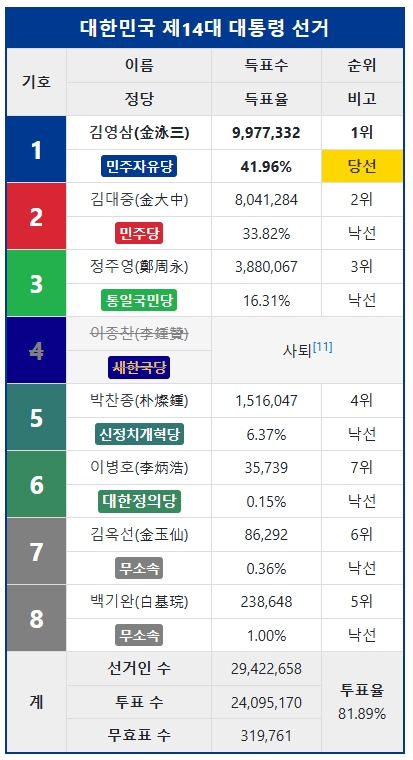

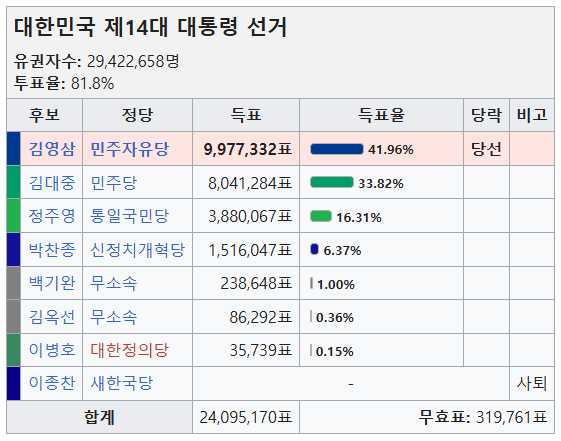